<a href="https://colab.research.google.com/github/gheb02/Statistical-Learning-Project/blob/main/CNN_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shap
import lime

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                                nn.ReLU(),
                                nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# --- ResNet Building Blocks (No Change) ---

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# --- Customizable ResNet Model Definition with Attention (No Pre-built Architectures) ---

class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1, add_attention=True,
                 zero_init_residual=False, groups=1, width_per_group=64,
                 replace_stride_with_dilation=None, norm_layer=None):
        """
        Customizable ResNet architecture.

        Args:
            block (nn.Module): Type of building block (e.g., BasicBlock or Bottleneck).
            layers (list): A list of integers indicating the number of blocks in each of the 4 stages.
                           Example: [2, 2, 2, 2] for ResNet18, [3, 4, 6, 3] for ResNet50.
            num_classes (int): Number of output classes for the final classification layer.
            add_attention (bool): Whether to add CBAM attention modules after each stage.
            zero_init_residual (bool): If True, zero-initialize the last BN in each
                                       residual branch, so that the residual branch starts
                                       with zeros, and each residual block behaves like an identity.
                                       This improves the accuracy of the model at the beginning of training.
            groups (int): Number of blocked connections from input channels to output channels.
            width_per_group (int): Base width of the output channels for each group.
            replace_stride_with_dilation (list, optional): If not None, a list of booleans
                                                            indicating whether to replace
                                                            the 2x2 stride with a dilated
                                                            convolution in stages 2, 3, and 4.
            norm_layer (callable, optional): Normalization layer to use (default: BatchNorm2d).
        """
        super(CustomResNet, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet stages (layers)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])

        # Final pooling and classification layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(p=0.5)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

        # Attention modules
        self.add_attention = add_attention
        if self.add_attention:
            # CBAM modules are instantiated based on the output channels of each layer
            self.cbam1 = CBAM(64 * block.expansion)
            self.cbam2 = CBAM(128 * block.expansion)
            self.cbam3 = CBAM(256 * block.expansion)
            self.cbam4 = CBAM(512 * block.expansion)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        if self.add_attention:
            x = self.cbam1(x)

        x = self.layer2(x)
        if self.add_attention:
            x = self.cbam2(x)

        x = self.layer3(x)
        if self.add_attention:
            x = self.cbam3(x)

        x = self.layer4(x)
        if self.add_attention:
            x = self.cbam4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.dropout(x)
        return x


In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

# --- Validation Loop ---
def validate_epoch(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy


# --- Test Loop ---
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    test_loss = running_loss / total_samples
    test_accuracy = correct_predictions / total_samples
    return test_loss, test_accuracy


In [20]:
# Setup
num_classes = 2  # Example: for CIFAR-10, change if your task is different
epochs = 20
batch_size = 128
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model (e.g., a ResNet-18 with attention)
model = CustomResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, add_attention=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Modifica questo con il percorso alla tua cartella
data_dir = "/content/drive/MyDrive/SL_Project/binary_one_type_split"

# Dimensione standard, modificabile
image_size = 256

# Trasformazioni da applicare: resize, tensorizzazione e normalizzazione
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # converte in [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # per 3 canali
])

# Dataset completo dalla cartella di training
full_train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

# Definisci le percentuali per train e validation
train_size = int(0.8 * len(full_train_dataset)) # 80% per il training effettivo
val_size = len(full_train_dataset) - train_size # 20% per la validation

# Split del dataset di training in train e validation sets
# Per riproducibilità dello split
g = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=g)

# DataLoader per batch
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False) # Shuffle False for val
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False) # Shuffle False for test

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 2416
Validation dataset size: 604
Test dataset size: 755


In [21]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 5 # Number of epochs to wait if validation loss doesn't improve
epochs_no_improve = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for epoch in range(epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0

    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}!")
            break # Exit the training loop

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"   Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"   Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

print("\nTraining complete.")



# --- Test Loop ---
test_loss, test_accuracy = test_model(model, test_loader, criterion, device)
print(f"\nTest Results:")
print(f"   Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")


Using device: cuda
Epoch 1/20:
   Train Loss: 0.4532, Train Acc: 0.7575
   Val Loss: 2.4884, Val Acc: 0.4371
Epoch 2/20:
   Train Loss: 0.2978, Train Acc: 0.8200
   Val Loss: 2.1573, Val Acc: 0.4387
Epoch 3/20:
   Train Loss: 0.2276, Train Acc: 0.8415
   Val Loss: 0.5923, Val Acc: 0.7235
Epoch 4/20:
   Train Loss: 0.1834, Train Acc: 0.8729
   Val Loss: 0.2176, Val Acc: 0.9222
Epoch 5/20:
   Train Loss: 0.1753, Train Acc: 0.8688
   Val Loss: 0.0881, Val Acc: 0.9669
Epoch 6/20:
   Train Loss: 0.1768, Train Acc: 0.8597
   Val Loss: 0.0911, Val Acc: 0.9702
Epoch 7/20:
   Train Loss: 0.1766, Train Acc: 0.8733
   Val Loss: 0.0673, Val Acc: 0.9768
Epoch 8/20:
   Train Loss: 0.1737, Train Acc: 0.8663
   Val Loss: 0.0806, Val Acc: 0.9735
Epoch 9/20:
   Train Loss: 0.1833, Train Acc: 0.8618
   Val Loss: 0.0722, Val Acc: 0.9768
Epoch 10/20:
   Train Loss: 0.1818, Train Acc: 0.8696
   Val Loss: 0.0724, Val Acc: 0.9768
Epoch 11/20:
   Train Loss: 0.1738, Train Acc: 0.8762
   Val Loss: 0.0785, Val A

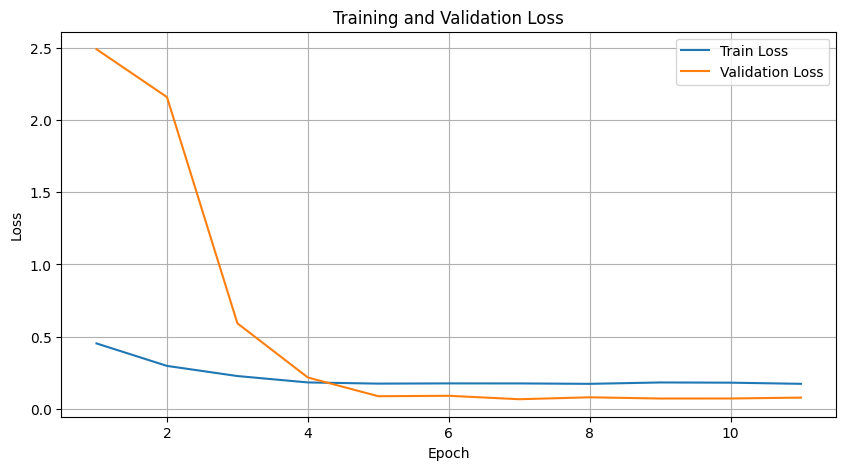

In [23]:
# --- Plotting ---
epochs_range = range(1, epoch + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

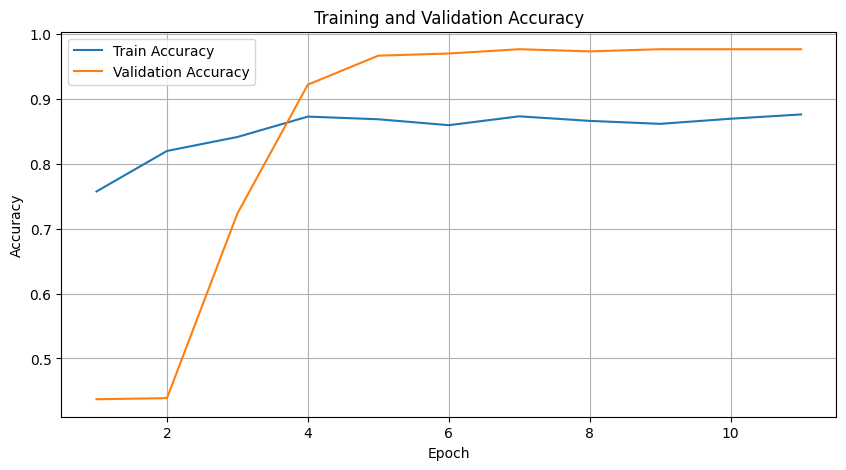

In [24]:
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, target_class=None):
        self.model.eval()
        output = self.model(input_image)
        if target_class is None:
            # For binary classification, you typically want the CAM for the predicted class
            # For a single sigmoid output, if output > 0.5, target class is 1, else 0
            # For CrossEntropyLoss, torch.argmax(output) gives the predicted class
            if self.model.fc.out_features == 1: # Binary classification with sigmoid output or raw logit
                 # For binary output (logit), the prediction is based on the sign
                 predicted_class = (output.item() > 0).long() # Get the single logit and compare
                 target_class = predicted_class.item()
            else: # Multi-class classification
                 target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        # If output is a single logit (num_classes=1), target_class won't be used directly for indexing
        # For a single output (binary classification), you backpropagate on the output itself.
        if self.model.fc.out_features == 1:
            # Backpropagate on the single output logit
            output.backward(gradient=torch.ones_like(output), retain_graph=True)
        else:
            one_hot_output = torch.zeros_like(output)
            one_hot_output[0][target_class] = 1
            output.backward(gradient=one_hot_output, retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        # Compute CAM
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = torch.relu(cam) # Apply ReLU to only keep positive contributions

        # Resize CAM to input image size
        cam = F.interpolate(cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max()

        # Detach before converting to numpy
        return cam.squeeze().detach().cpu().numpy()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


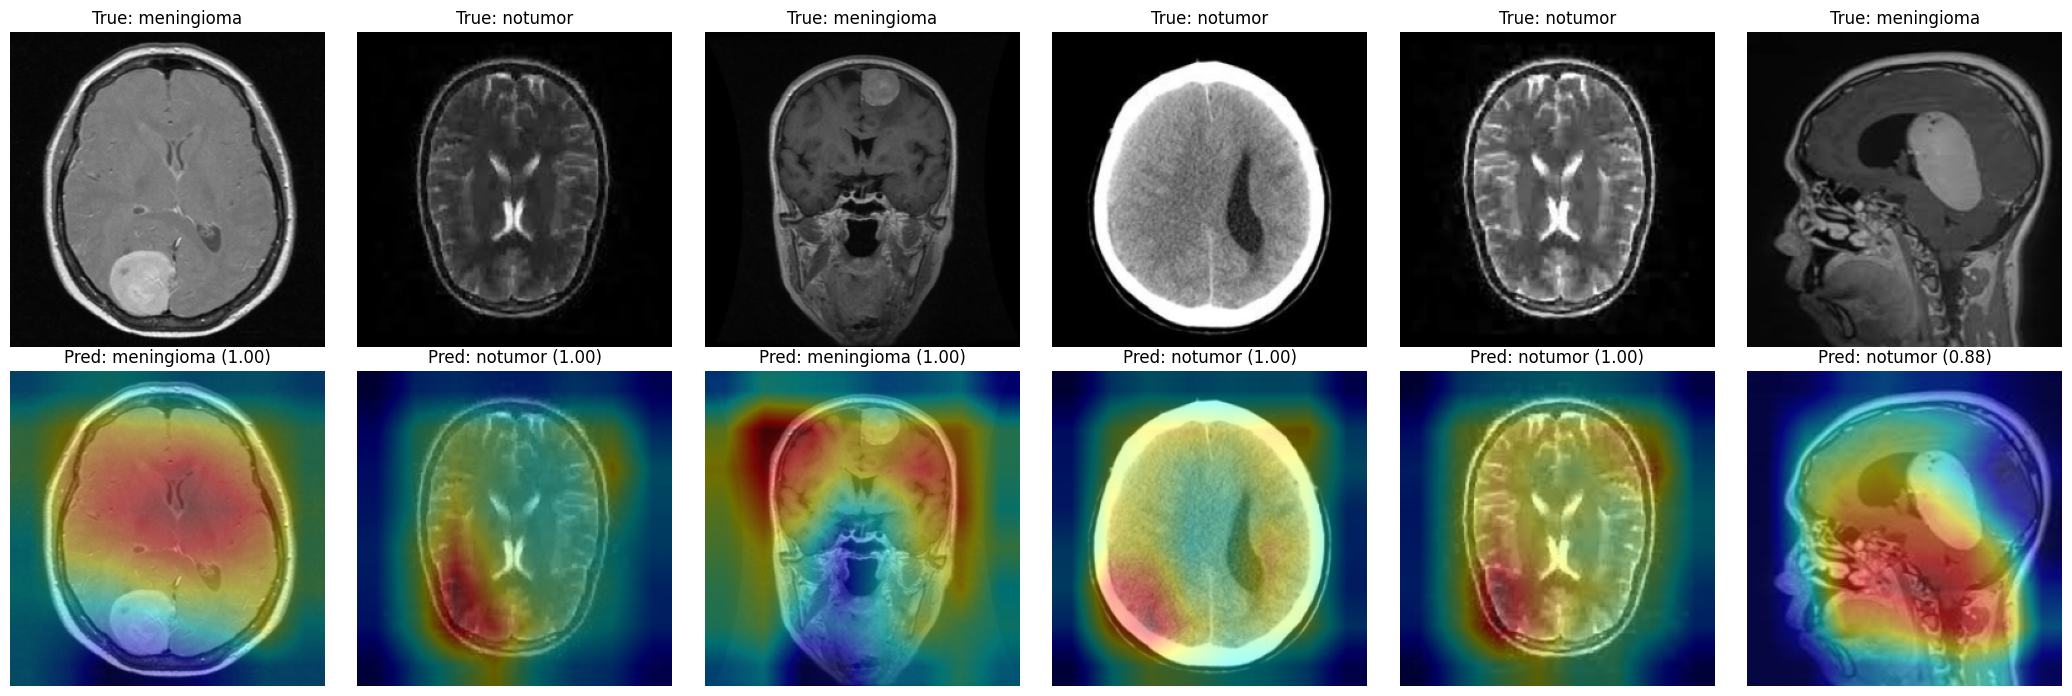

In [32]:
# Load a sample image from the test set
model.eval() # Ensure the classifier is in eval mode

# Instantiate GradCAM
# We need to target the last convolutional layer of the encoder within the classifier model
# For CustomResNet, the last convolutional layer before pooling is `model.layer4`
# If `add_attention` is True and you want to see the effect after attention, you could target `model.cbam4`.
# For general feature maps, `model.layer4` is a good choice.
target_layer_for_cam = model.layer4 # This is the crucial change for your model structure
grad_cam = GradCAM(model, target_layer_for_cam)

num_images_to_show = 6 # Number of random images to visualize

# --- MODIFICATION START ---
# Get random indices from the test_dataset
total_test_samples = len(test_dataset)
random_indices = random.sample(range(total_test_samples), num_images_to_show)

# Adjust figure size dynamically
# We'll plot two rows: Original Image and Superimposed CAM for predicted class
plt.figure(figsize=(num_images_to_show * 3.5, 7)) # Adjusted size for better display
# --- MODIFICATION END ---

for i, idx in enumerate(random_indices):
    # Retrieve the image and label using the random index from the dataset
    sample_data_transformed, true_label = test_dataset[idx] # This already has eval_transform applied

    # Add batch dimension and move to device
    sample_image = sample_data_transformed.unsqueeze(0).to(device)
    true_label_item = true_label # Label is already an int

    # Ensure the input image for Grad-CAM has requires_grad=True
    # Detach and clone is good practice to ensure it's a leaf variable for CAM
    sample_image_for_cam = sample_image.clone().detach().requires_grad_(True)

    # Get CAM (e.g., for predicted class)
    cam_output = grad_cam(sample_image_for_cam)

    # De-normalize and display the original image
    # The normalization was (x - 0.5) / 0.5, so reverse is x * 0.5 + 0.5
    original_image_display = (sample_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5
    original_image_display = np.clip(original_image_display, 0, 1) # Clip to ensure valid RGB range

    # Overlay CAM on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_output), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1] # Convert BGR to RGB (OpenCV default is BGR)

    original_image_display_float = np.float32(original_image_display)

    # Superimpose the heatmap on the original image
    # You might want to experiment with the alpha blending factor
    alpha = 0.6 # Adjust transparency of heatmap
    superimposed_img = original_image_display_float + heatmap * alpha
    superimposed_img = superimposed_img / np.max(superimposed_img) # Normalize to prevent clipping (values > 1)
    superimposed_img = np.clip(superimposed_img, 0, 1) # Ensure values are within [0, 1]

    # Get predicted class and probability for display
    with torch.no_grad():
        # Make sure to use the correct model for prediction
        # model(sample_image) will output shape [1, 2] for num_classes=2
        output_logits = model(sample_image)

        # For binary classification with CrossEntropyLoss,
        # argmax gives the predicted class index (0 or 1)
        predicted_class_tensor = torch.argmax(output_logits, dim=1)
        predicted_class = predicted_class_tensor.item() # Now it's a single value, can use .item()

        # To get probability for the predicted class, apply softmax and get the value
        # For binary classification, often only the probability of class 1 is displayed
        probabilities = torch.softmax(output_logits, dim=1)
        # If you want the probability of the *predicted* class:
        predicted_prob = probabilities[0, predicted_class].item()
        # If you want the probability of class 1 (useful for binary display):
        # predicted_prob = probabilities[0, 1].item()


    # Plotting - Adjusted subplot indexing for random order
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(original_image_display)
    plt.title(f"True: {test_dataset.classes[true_label_item]}") # Display class name if available
    plt.axis('off')

    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(superimposed_img)
    # Use the predicted class name and its probability
    plt.title(f"Pred: {test_dataset.classes[predicted_class]} ({predicted_prob:.2f})") # Display class name and probability
    plt.axis('off')

plt.tight_layout()
plt.show()